Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.586415
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.994001
Minibatch accuracy: 37.5%
Validation accuracy: 32.8%
Minibatch loss at step 100: 1.210225
Minibatch accuracy: 50.0%
Validation accuracy: 63.2%
Minibatch loss at step 150: 0.458391
Minibatch accuracy: 75.0%
Validation accuracy: 71.6%
Minibatch loss at step 200: 0.863169
Minibatch accuracy: 75.0%
Validation accuracy: 75.4%
Minibatch loss at step 250: 1.461454
Minibatch accuracy: 62.5%
Validation accuracy: 77.0%
Minibatch loss at step 300: 0.352217
Minibatch accuracy: 87.5%
Validation accuracy: 78.2%
Minibatch loss at step 350: 0.520905
Minibatch accuracy: 87.5%
Validation accuracy: 76.0%
Minibatch loss at step 400: 0.304292
Minibatch accuracy: 87.5%
Validation accuracy: 79.6%
Minibatch loss at step 450: 0.743755
Minibatch accuracy: 87.5%
Validation accuracy: 79.7%
Minibatch loss at step 500: 0.732359
Minibatch accuracy: 87.5%
Validation accuracy: 81.4%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
def plot_results(steps, minibatch_loss, minibatch_acc, validation_acc):
    # Plot minibatch loss
    plt.plot(steps, minibatch_loss, 'g-')
    plt.title('Minibatch Loss')
    plt.xlabel('Step')
    plt.ylabel('Minibatch Loss')          
    plt.show()

    # Plot minibatch and aalidation accuracy
    plt.plot(steps, minibatch_acc, 'b-', label='Minibatch Accuracy')
    plt.plot(steps, validation_acc, 'r--', label='Validation Accuracy')
    plt.title('Minibatch and Validation Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')          
    plt.show()

In [9]:
def train_with_max_pool(batch_size, patch_size, depth, num_hidden, num_steps):      
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'):
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

        with tf.name_scope('layers'):
            layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
            layer1_biases = tf.Variable(tf.zeros([depth]))
            layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
            layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
            layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
            layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
            layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
            layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
        def model(data):
            conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            hidden1 = tf.nn.relu(conv1 + layer1_biases)
            pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')            
            conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
            hidden2 = tf.nn.relu(conv2 + layer2_biases)
            pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')            
            shape = pool2.get_shape().as_list()
            reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            return tf.matmul(hidden, layer4_weights) + layer4_biases
      
        logits = model(tf_train_dataset)
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
            tf.summary.scalar('loss', loss)

        with tf.name_scope('train'):
            optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        test_prediction = tf.nn.softmax(model(tf_test_dataset))

        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            print('Initialized')
            minibatch_loss = []
            minibatch_acc = []
            validation_acc = []
            eval_every = 200
            for step in range(num_steps):
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % eval_every == 0):
                    minibatch_loss.append(l) 
                    minibatch_acc.append(accuracy(predictions, batch_labels))
                    validation_acc.append(accuracy(valid_prediction.eval(), valid_labels))
                if (step % 2000 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)               
                    print('  Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                    print('  Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
            steps = range(0, num_steps, eval_every)
            plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)        

Initialized
Step: 0
  Minibatch loss: 3.356258
  Minibatch accuracy: 6.2%
  Validation accuracy: 10.0%
Step: 2000
  Minibatch loss: 0.114893
  Minibatch accuracy: 100.0%
  Validation accuracy: 85.9%
Step: 4000
  Minibatch loss: 0.353464
  Minibatch accuracy: 87.5%
  Validation accuracy: 87.3%
Step: 6000
  Minibatch loss: 0.034975
  Minibatch accuracy: 100.0%
  Validation accuracy: 88.3%
Step: 8000
  Minibatch loss: 0.524117
  Minibatch accuracy: 81.2%
  Validation accuracy: 88.6%
Step: 10000
  Minibatch loss: 0.133205
  Minibatch accuracy: 93.8%
  Validation accuracy: 88.4%
Test accuracy: 94.3%


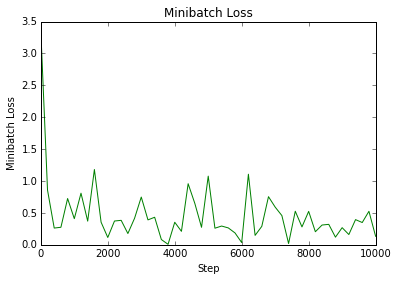

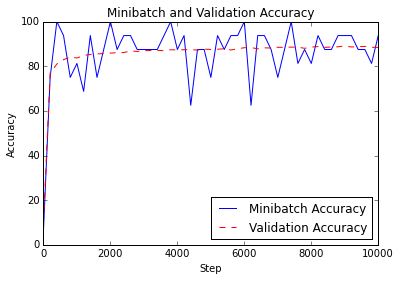

Wall time: 11min 11s


In [10]:
%time train_with_max_pool(16, 5, 16, 64, 10001)

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [11]:
def train_with_dropout(batch_size, patch_size, depth, num_hidden, dropout_rate, num_steps):
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)
  
        with tf.name_scope('layers'):
            layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
            layer1_biases = tf.Variable(tf.zeros([depth]))
            layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
            layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
            layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
            layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
            layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
            layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
   
        def model(data, keep_prob):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer1_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer2_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            shape = pool.get_shape().as_list()
            reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            hidden = tf.nn.dropout(hidden, dropout_rate)  # dropout_rate
            return tf.matmul(hidden, layer4_weights) + layer4_biases       

        # Training computation.
        logits = model(tf_train_dataset, dropout_rate)
        with tf.name_scope('loss'):           
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        with tf.name_scope('train'):
            optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
        test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 200
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                minibatch_acc.append(accuracy(predictions, batch_labels))
                validation_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            if (step % 1000 == 0):
                print("Step: %d" % step)
                print("  Minibatch loss: %f" % l)
                print('  Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('  Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  

Initialized
Step: 0
  Minibatch loss: 4.063739
  Minibatch accuracy: 18.8%
  Validation accuracy: 9.8%
Step: 1000
  Minibatch loss: 0.378987
  Minibatch accuracy: 93.8%
  Validation accuracy: 83.4%
Step: 2000
  Minibatch loss: 0.180803
  Minibatch accuracy: 93.8%
  Validation accuracy: 84.9%
Step: 3000
  Minibatch loss: 0.833177
  Minibatch accuracy: 87.5%
  Validation accuracy: 86.6%
Step: 4000
  Minibatch loss: 0.349728
  Minibatch accuracy: 93.8%
  Validation accuracy: 86.6%
Step: 5000
  Minibatch loss: 0.896563
  Minibatch accuracy: 75.0%
  Validation accuracy: 87.4%
Step: 6000
  Minibatch loss: 0.047602
  Minibatch accuracy: 100.0%
  Validation accuracy: 87.8%
Step: 7000
  Minibatch loss: 0.657171
  Minibatch accuracy: 75.0%
  Validation accuracy: 87.7%
Step: 8000
  Minibatch loss: 0.512469
  Minibatch accuracy: 81.2%
  Validation accuracy: 87.9%
Step: 9000
  Minibatch loss: 0.191726
  Minibatch accuracy: 93.8%
  Validation accuracy: 88.4%
Step: 10000
  Minibatch loss: 0.113506
  

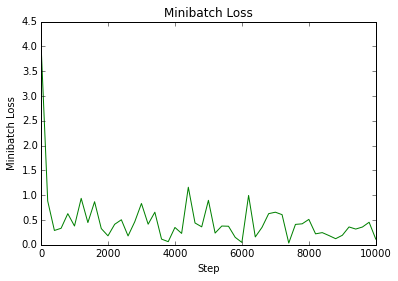

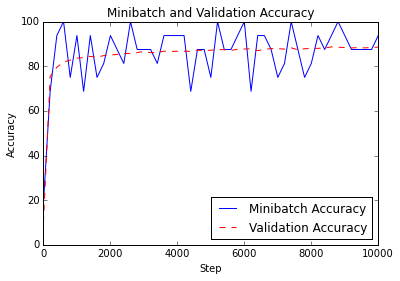

Wall time: 10min 36s


In [12]:
%time train_with_dropout(16, 5, 16, 64, 0.95, 10001)

In [13]:
def train_with_decay(batch_size, patch_size, depth, num_hidden, num_steps):
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)
  
        with tf.name_scope('layers'):
            layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
            layer1_biases = tf.Variable(tf.zeros([depth]))
            layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
            layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
            layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
            layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
            layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
            layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
   
        def model(data):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer1_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer2_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            shape = pool.get_shape().as_list()
            reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)           
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset)
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

        with tf.name_scope('train'):
            learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        test_prediction = tf.nn.softmax(model(tf_test_dataset))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 200
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                minibatch_acc.append(accuracy(predictions, batch_labels))
                validation_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            if (step % 1000 == 0):
                print("Step: %d" % step)
                print("  Minibatch loss: %f" % l)
                print('  Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('  Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))  
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  

Initialized
Step: 0
  Minibatch loss: 3.538600
  Minibatch accuracy: 12.5%
  Validation accuracy: 15.2%
Step: 1000
  Minibatch loss: 0.457493
  Minibatch accuracy: 87.5%
  Validation accuracy: 83.9%
Step: 2000
  Minibatch loss: 0.066364
  Minibatch accuracy: 100.0%
  Validation accuracy: 86.5%
Step: 3000
  Minibatch loss: 0.654240
  Minibatch accuracy: 87.5%
  Validation accuracy: 87.0%
Step: 4000
  Minibatch loss: 0.437226
  Minibatch accuracy: 87.5%
  Validation accuracy: 87.7%
Step: 5000
  Minibatch loss: 1.006887
  Minibatch accuracy: 81.2%
  Validation accuracy: 87.6%
Step: 6000
  Minibatch loss: 0.062700
  Minibatch accuracy: 100.0%
  Validation accuracy: 87.9%
Step: 7000
  Minibatch loss: 0.642586
  Minibatch accuracy: 75.0%
  Validation accuracy: 88.5%
Step: 8000
  Minibatch loss: 0.439353
  Minibatch accuracy: 81.2%
  Validation accuracy: 88.5%
Step: 9000
  Minibatch loss: 0.189367
  Minibatch accuracy: 93.8%
  Validation accuracy: 88.7%
Step: 10000
  Minibatch loss: 0.073138


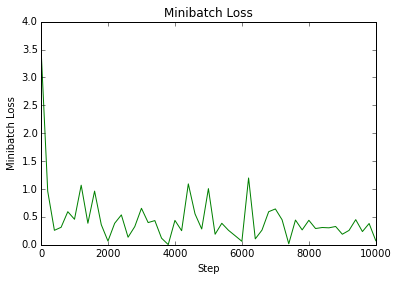

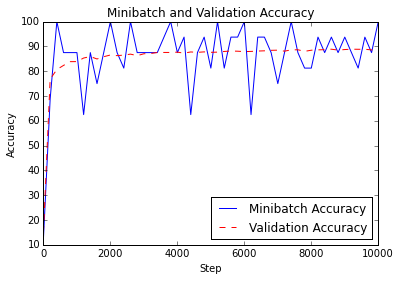

Wall time: 11min 32s


In [14]:
%time train_with_decay(16, 5, 16, 64, 10001)

In [15]:
def train_with_dropout_and_decay(batch_size, patch_size, depth, num_hidden, dropout_rate, num_steps):
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)
  
        with tf.name_scope('layers'):
            layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
            layer1_biases = tf.Variable(tf.zeros([depth]))
            layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
            layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
            layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
            layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
            layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
            layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
   
        def model(data, keep_prob):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer1_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')    
            hidden = tf.nn.relu(conv + layer2_biases)
            pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            shape = pool.get_shape().as_list()
            reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            hidden = tf.nn.dropout(hidden, dropout_rate)  # dropout
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, dropout_rate)
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

        with tf.name_scope('train'):
            learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)  # decay
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
        test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 200
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                minibatch_acc.append(accuracy(predictions, batch_labels))
                validation_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            if (step % 1000 == 0):
                print("Step: %d" % step)
                print("  Minibatch loss: %f" % l)
                print('  Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('  Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  

Initialized
Step: 0
  Minibatch loss: 4.828048
  Minibatch accuracy: 6.2%
  Validation accuracy: 10.0%
Step: 1000
  Minibatch loss: 0.288150
  Minibatch accuracy: 87.5%
  Validation accuracy: 84.0%
Step: 2000
  Minibatch loss: 0.088006
  Minibatch accuracy: 100.0%
  Validation accuracy: 85.0%
Step: 3000
  Minibatch loss: 0.656079
  Minibatch accuracy: 87.5%
  Validation accuracy: 86.6%
Step: 4000
  Minibatch loss: 0.389470
  Minibatch accuracy: 87.5%
  Validation accuracy: 87.3%
Step: 5000
  Minibatch loss: 1.054723
  Minibatch accuracy: 81.2%
  Validation accuracy: 87.5%
Step: 6000
  Minibatch loss: 0.137214
  Minibatch accuracy: 93.8%
  Validation accuracy: 87.7%
Step: 7000
  Minibatch loss: 0.539389
  Minibatch accuracy: 93.8%
  Validation accuracy: 87.9%
Step: 8000
  Minibatch loss: 0.495099
  Minibatch accuracy: 81.2%
  Validation accuracy: 88.3%
Step: 9000
  Minibatch loss: 0.222407
  Minibatch accuracy: 93.8%
  Validation accuracy: 88.4%
Step: 10000
  Minibatch loss: 0.084542
  

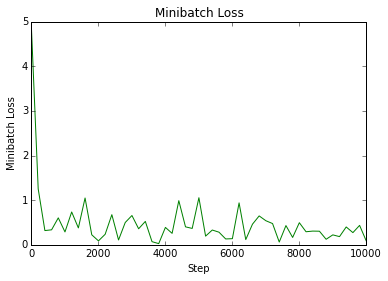

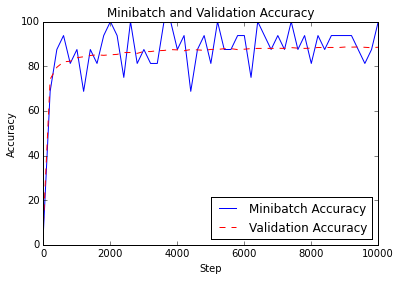

Wall time: 13min 13s


In [16]:
%time train_with_dropout_and_decay(16, 5, 16, 64, 0.95, 10001)